In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
dt_unclean = pd.read_excel("./data/for_textclassification_data.xlsx")

In [5]:
df = dt_unclean.dropna(subset=["Comment"])

In [6]:
category_mapping = {
    'internet banking': 'ib or mb',
    'mobile banking': 'ib or mb',
    'cctr': 'cctr/chatbot/live agent',
    'chatbot or live agent': 'cctr/chatbot/live agent',
    'cctr or chatbot': 'cctr/chatbot/live agent',
}

# Use the replace method to merge categories
df['channels'] = df['channels'].replace(category_mapping)

C:\Users\Xavior\AppData\Local\Temp\ipykernel_31608\2126052350.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['channels'] = df['channels'].replace(category_mapping)


In [10]:
print("No. of reviews for ib/mb: ", len(df.loc[df.channels == 'ib or mb']))
print("No. of reviews for cctr/chatbot/live agent: ", len(df.loc[df.channels == 'cctr/chatbot/live agent']))
print("No. of reviews for pweb: ", len(df.loc[df.channels == 'pweb']))

No. of reviews for ib/mb:  488
No. of reviews for cctr/chatbot/live agent:  203
No. of reviews for pweb:  441


In [11]:
category_to_include = ['ib or mb', 'pweb', 'cctr/chatbot/live agent','0']

In [12]:
combined_df = pd.DataFrame(columns=['channels'])

In [29]:

# Initialize an empty DataFrame to store the balanced dataset
balanced_df = pd.DataFrame(columns=df.columns)

# List of unique channel values
unique_channels = df['channels'].unique()

# Specify the number of rows to sample for each channel (e.g., 200)
sample_size = 200

# Balance the dataset by sampling 200 rows for each unique channel value
for channel in category_to_include:
    channel_data = df[df['channels'] == channel]
    if len(channel_data) >= sample_size:
        if channel in ['ib or mb','pweb']:
            balanced_df = balanced_df.append(channel_data.sample(sample_size + 60))
        else:
            balanced_df = balanced_df.append(channel_data.sample(sample_size))
    else:
        balanced_df = balanced_df.append(channel_data)

# Reset the index of the balanced DataFrame
balanced_df.reset_index(drop=True, inplace=True)

C:\Users\Xavior\AppData\Local\Temp\ipykernel_31608\1200258598.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_df = balanced_df.append(channel_data.sample(sample_size + 60))
C:\Users\Xavior\AppData\Local\Temp\ipykernel_31608\1200258598.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_df = balanced_df.append(channel_data.sample(sample_size + 60))
C:\Users\Xavior\AppData\Local\Temp\ipykernel_31608\1200258598.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  balanced_df = balanced_df.append(channel_data.sample(sample_size))
C:\Users\Xavior\AppData\Local\Temp\ipykernel_31608\1200258598.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Us

In [14]:
balanced_df

,Code,Channel,Survey Type,Bank Type,Language,Country,Page Type,Title of page,Link,Rate,Issues,Comment,channels,group,notes,Date,Module Visited,SysgenID,Column19
0,493379c0-e99e-4717-bbf2-0f94d54c0bab,PWEB,Overall,personal,en,sg,loans,Buying Your HDB Flat - Bank Loan Interest Rate...,https://www.dbs.com.sg/personal/loans/homeloan...,2,Technical,App hangs,ib or mb,0,NaN,2021-05-18 21:23:05,pweb,NaN,NaN
1,93e62b57-01ec-4446-96f7-555834098022,PWEB,Overall,personal,en,sg,default.page,"Bank Accounts, Cards, Loans, Financial Plannin...",https://www.dbs.com.sg/personal/default.page,1,"Technical,Other",I login in less than 2 minutes and access my s...,ib or mb,technical-logging,NaN,2021-05-18 10:24:59,pweb,NaN,NaN
2,394b01d7-ae14-419e-ad56-97bdb9c1d302,PWEB,Overall,personal,en,sg,investments,CPF Investment Account DBS Singapore,https://www.dbs.com.sg/personal/investments/sr...,1,Other,Investment Awareness Quiz is not made known to...,ib or mb,technical-logging,NaN,2021-05-26 14:59:57,pweb,NaN,NaN
3,7fc2c747-ea4e-4958-a175-685ed0249fab,PWEB,Overall,personal,en,sg,default.page,"Bank Accounts, Cards, Loans, Financial Plannin...",https://www.dbs.com.sg/personal/default.page,1,Technical,why downloading of my estatement also FAILED -...,ib or mb,technical-statements,NaN,2021-05-23 12:28:09,pweb,NaN,NaN
4,34a4f70a-1d54-4194-b41b-6b078db1daa3,PWEB,Overall,personal,en,sg,deposits,Digital Token DBS Singapore,https://www.dbs.com.sg/personal/deposits/bank-...,1,Other,I didn't like to set up token.. can I straight...,ib or mb,technical-logging-authentication-token,NaN,2021-05-02 10:51:23,pweb,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,8d8f289d-36d8-49b3-a227-6aa207bdbb42,PWEB,Overall,treasures,en,sg,articles,How to keep up with foreign exchange rates eff...,https://www.dbs.com.sg/treasures/articles/weal...,4,NaN,dont interrupt me with ads while i am still br...,0,content-advertisement,NaN,2021-05-15 14:27:30,pweb,NaN,NaN
996,151d7519-d4d4-4653-9f21-927ff943a7aa,PWEB,Overall,personal,en,sg,promotion,Apply for a DBS Visa Debit Card DBS Singapore,https://www.dbs.com.sg/personal/promotion/card...,5,NaN,Sorry my card is spaal raday Then I went new card,0,0,NaN,2021-05-13 16:06:41,pweb,NaN,NaN
997,5e6e49fa-a6a4-4713-bba4-1bfd758c4e0e,PWEB,Overall,posb,en,sg,deposits,POSB digibank online POSB Singapore,https://www.posb.com.sg/personal/deposits/bank...,5,NaN,-,0,0,NaN,2021-05-12 13:34:01,pweb,NaN,NaN
998,08f498f1-173a-476b-befc-3b74f90247d9,PWEB,Overall,posb,en,sg,investments,Supplementary Retirement Scheme POSB Singapore,https://www.posb.com.sg/personal/investments/s...,5,NaN,Ok,0,0,NaN,2021-05-03 10:43:05,pweb,NaN,NaN


In [30]:
balanced_df.shape[0]

920

In [31]:
labels = balanced_df["channels"].unique()
labels

array(['ib or mb', 'pweb', 'cctr/chatbot/live agent', '0'], dtype=object)

In [32]:
print("No. of reviews for ib/mb: ", len(balanced_df.loc[balanced_df.channels == 'ib or mb']))
print("No. of reviews for cctr/chatbot/live agent: ", len(balanced_df.loc[balanced_df.channels == 'cctr/chatbot/live agent']))
print("No. of reviews for unspecified: ", len(balanced_df.loc[balanced_df.channels == '0']))
print("No. of reviews for pweb: ", len(balanced_df.loc[balanced_df.channels == 'pweb']))


No. of reviews for ib/mb:  260
No. of reviews for cctr/chatbot/live agent:  200
No. of reviews for unspecified:  200
No. of reviews for pweb:  260


In [36]:
# Replace '0' with 'unspecified' in the 'channels' column
balanced_df['channels'] = balanced_df['channels'].replace('0', 'unspecified')

In [34]:
# Initialize the BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
bert_model = BertModel.from_pretrained("bert-base-uncased")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
# Tokenize and generate BERT embeddings for your reviews
def generate_bert_embeddings(text):
    inputs = tokenizer(text, padding=True, truncation=True, return_tensors="pt", max_length=128)
    with torch.no_grad():
        outputs = bert_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)  # Average pooling

In [38]:
# Apply BERT embeddings to your entire dataset
embeddings = balanced_df.Comment.apply(generate_bert_embeddings)

In [39]:
# Combine the embeddings into a feature matrix
X = torch.cat(embeddings.tolist()).numpy()

In [40]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, balanced_df["channels"], test_size=0.25, random_state=42)

In [54]:
# Train a multi-class SVM model
svm_model = SVC(kernel='linear', decision_function_shape='ovr',C=0.5)
svm_model.fit(X_train, y_train)

SVC(C=0.5, kernel='linear')

In [55]:
# Evaluate the SVM model
y_pred = svm_model.predict(X_test)
print(classification_report(y_test, y_pred))

                         precision    recall  f1-score   support

cctr/chatbot/live agent       0.73      0.78      0.76        46
               ib or mb       0.70      0.75      0.72        61
                   pweb       0.70      0.65      0.67        71
            unspecified       0.80      0.75      0.77        52

               accuracy                           0.73       230
              macro avg       0.73      0.73      0.73       230
           weighted avg       0.73      0.73      0.73       230



In [56]:
class_labels = balanced_df["channels"].unique()

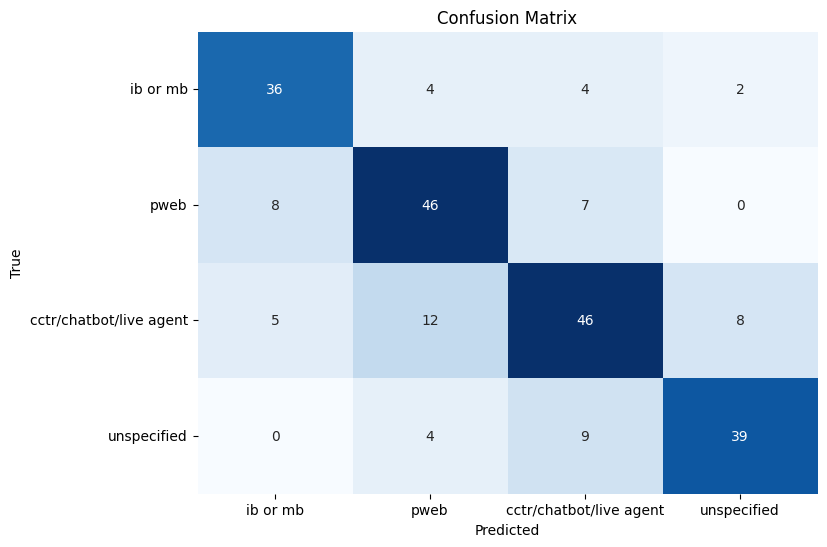

In [57]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a heatmap for visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()